# Pygrib을 이용하여 grib 파일 분석 및 태풍 탐지
## 기본 설정

In [125]:
import pygrib
import pandas as pd
import numpy as np
from scipy import stats

In [126]:
file_path = "/home/ish/DataProcessing_TRC/data/grib/gdas1.fnl0p25.2023072406.f00.grib2"

In [127]:
# 파일 열기
grbs = pygrib.open(file_path)

# 첫 번째 메시지 가져오기
grb = grbs[1]

print("사용 가능한 키:")
for key in grb.keys():
    print(key)

# 데이터 추출
pressure_data, lats, lons = grb.data()

# 파일 닫기
grbs.close()

사용 가능한 키:
globalDomain
GRIBEditionNumber
tablesVersionLatestOfficial
tablesVersionLatest
grib2divider
angleSubdivisions
missingValue
ieeeFloats
isHindcast
section0Length
identifier
discipline
editionNumber
totalLength
sectionNumber
section1Length
numberOfSection
centre
centreDescription
subCentre
tablesVersion
masterDir
localTablesVersion
significanceOfReferenceTime
year
month
day
hour
minute
second
dataDate
julianDay
dataTime
productionStatusOfProcessedData
typeOfProcessedData
md5Section1
selectStepTemplateInterval
selectStepTemplateInstant
stepType
is_chemical
is_chemical_distfn
is_chemical_srcsink
is_aerosol
is_aerosol_optical
setCalendarId
deleteCalendarId
sectionNumber
grib2LocalSectionPresent
deleteLocalDefinition
sectionNumber
gridDescriptionSectionPresent
section3Length
numberOfSection
sourceOfGridDefinition
numberOfDataPoints
numberOfOctectsForNumberOfPoints
interpretationOfNumberOfPoints
PLPresent
gridDefinitionTemplateNumber
gridDefinitionDescription
shapeOfTheEarth
scaleFac

In [128]:

print("----기본 정보----")
print(f"GRIB 버전: {grb.GRIBEditionNumber}")
print(f"Discipline: {grb.discipline}")
print(f"센터: {grb.centreDescription}")

print("\n----시간 정보----")
print(f"데이터 날짜: {grb.dataDate}")
print(f"데이터 시간: {grb.dataTime}")
print(f"예보 시간: {grb.forecastTime}")
print(f"유효 날짜: {grb.validityDate}")
print(f"유효 시간: {grb.validityTime}")

print("\n----공간 정보----")
print(f"격자 유형: {grb.gridType}")
print(f"격자 크기: {grb.Ni} x {grb.Nj}")
print(f"첫 격자점 (위도, 경도): ({grb.latitudeOfFirstGridPointInDegrees}, {grb.longitudeOfFirstGridPointInDegrees})")
print(f"마지막 격자점 (위도, 경도): ({grb.latitudeOfLastGridPointInDegrees}, {grb.longitudeOfLastGridPointInDegrees})")

print("\n----변수 정보----")
print(f"변수 이름: {grb.name}")
print(f"변수 약어: {grb.shortName}")
print(f"단위: {grb.units}")
print(f"매개변수 카테고리: {grb.parameterCategory}")
print(f"매개변수 번호: {grb.parameterNumber}")

print("\n----레벨 정보----")
print(f"레벨 유형: {grb.typeOfLevel}")
print(f"레벨 값: {grb.level}")

print("\n----데이터 표현----")
print(f"데이터 포인트 수: {grb.numberOfValues}")
print(f"압축 방식: {grb.packingType}")
print(f"비트 수/값: {grb.bitsPerValue}")

print("\n----통계 정보----")
print(f"최대값: {grb.maximum}")
print(f"최소값: {grb.minimum}")
print(f"평균: {grb.average}")
print(f"표준편차: {grb.standardDeviation}")

----기본 정보----
GRIB 버전: 2
Discipline: 0
센터: US National Weather Service - NCEP

----시간 정보----
데이터 날짜: 20230724
데이터 시간: 600
예보 시간: 0
유효 날짜: 20230724
유효 시간: 600

----공간 정보----
격자 유형: regular_ll
격자 크기: 1440 x 721
첫 격자점 (위도, 경도): (90.0, 0.0)
마지막 격자점 (위도, 경도): (-90.0, 359.75)

----변수 정보----
변수 이름: Pressure reduced to MSL
변수 약어: prmsl
단위: Pa
매개변수 카테고리: 3
매개변수 번호: 1

----레벨 정보----
레벨 유형: meanSea
레벨 값: 0

----데이터 표현----
데이터 포인트 수: 1038240
압축 방식: grid_complex_spatial_differencing
비트 수/값: 14

----통계 정보----
최대값: 106282.68125000001
최소값: 94095.88125
평균: 100898.37076801856
표준편차: 1365.8394072584374


# 이상치 탐지 
일단 이상한 기압. 즉 태풍이 있는지 수치, 그래프로 확인해보자 

## Z-Score
데이터가 평균으로부터 몇 표준편차 떨어져 있는지 계산. 
일반적으로 Z-점수의 절대값이 3보다 크면 이상치로 간주

In [129]:
# 데이터 평탄화 (2D 배열을 1D로 변환)
pressure_flat = pressure_data.flatten()

# Z-점수 계산
z_scores = stats.zscore(pressure_flat)

# 이상치 기준 설정 (Z-점수 절대값 > 3)
outliers_z = np.where(np.abs(z_scores) > 3)

# 전체 데이터 개수와 이상치 비율 계산
total_count = len(pressure_flat)
outliers_count = len(outliers_z[0])
outliers_ratio = (outliers_count / total_count) * 100

print(f"총 데이터 개수: {total_count:,}")
print(f"Z-점수 이상치 개수: {outliers_count:,}")
print(f"이상치 비율: {outliers_ratio:.2f}%")


총 데이터 개수: 1,038,240
Z-점수 이상치 개수: 17,011
이상치 비율: 1.64%


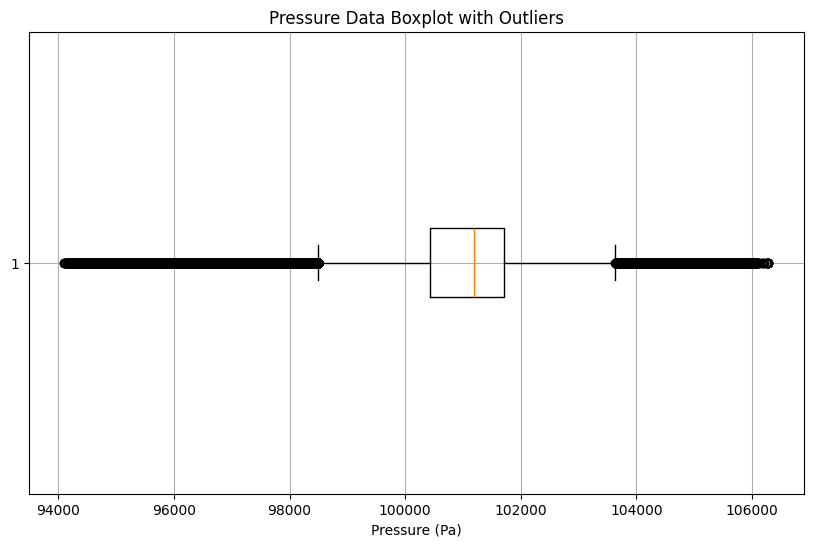

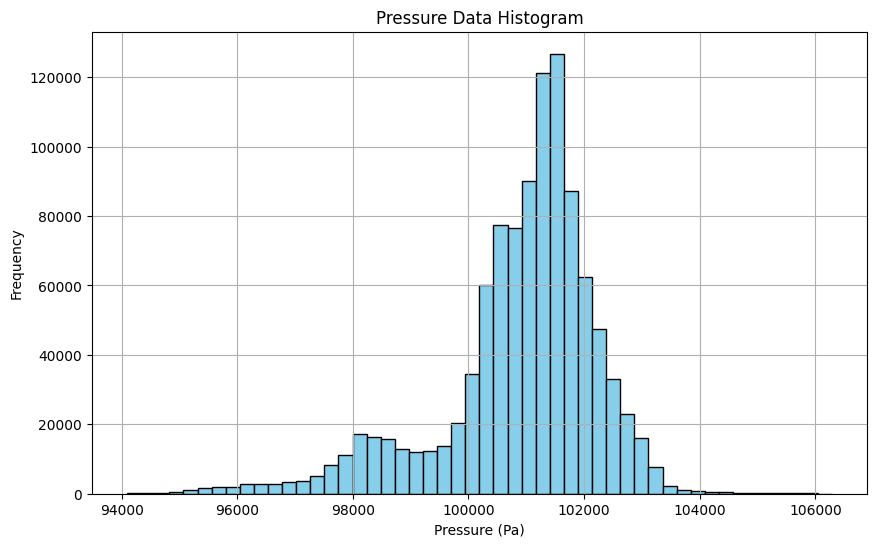

In [130]:
import matplotlib.pyplot as plt

# 박스플롯 생성
plt.figure(figsize=(10, 6))
plt.boxplot(pressure_flat, vert=False)
plt.title('Pressure Data Boxplot with Outliers')
plt.xlabel('Pressure (Pa)')
plt.grid(True)
plt.show()

# 히스토그램 생성
plt.figure(figsize=(10, 6))
plt.hist(pressure_flat, bins=50, color='skyblue', edgecolor='black')
plt.title('Pressure Data Histogram')
plt.xlabel('Pressure (Pa)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## 사분위수 범위 (IQR)
Q1(25% 백분위수)과 Q3(75% 백분위수) 사이의 범위를 계산.
Q1 - 1.5 * IQR 미만이거나 Q3 + 1.5 * IQR 초과인 값을 이상치로 간주

In [131]:
# 사분위수 계산
Q1 = np.percentile(pressure_data, 25)
Q3 = np.percentile(pressure_data, 75)
IQR = Q3 - Q1

# 이상치 기준 설정 (1.5 * IQR 초과)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = pressure_data[(pressure_data < lower_bound) | (pressure_data > upper_bound)]
print(f"IQR 이상치 개수: {len(outliers_iqr)}")


IQR 이상치 개수: 85608


### 두 score의 차이를 시각화

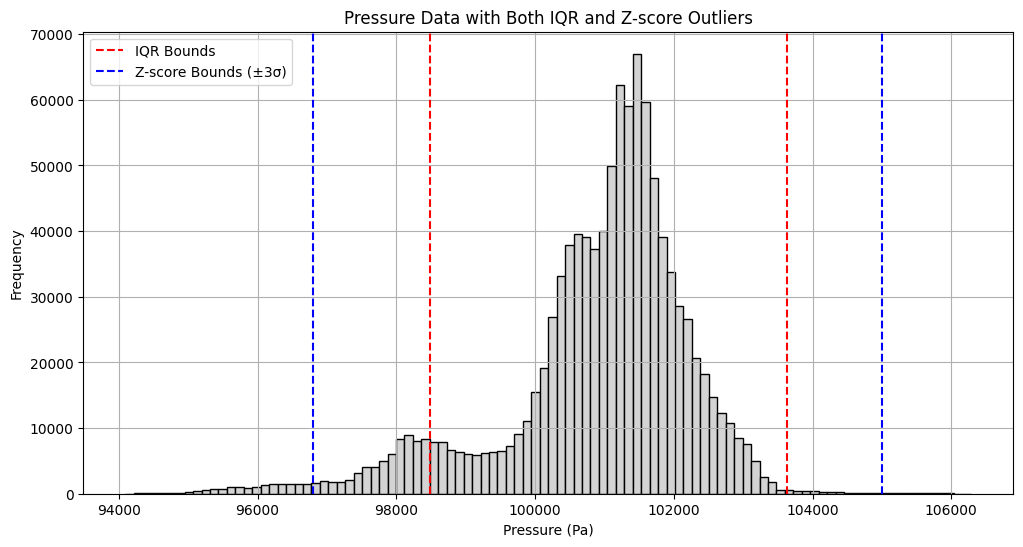

In [132]:

# Z-score와 IQR 이상치를 모두 표시하는 히스토그램
plt.figure(figsize=(12, 6))
plt.hist(pressure_flat, bins=100, color='lightgray', edgecolor='black')

# IQR 경계선
plt.axvline(x=lower_bound, color='red', linestyle='--', label='IQR Bounds')
plt.axvline(x=upper_bound, color='red', linestyle='--')

# Z-score 경계선
mean = np.mean(pressure_flat)
std = np.std(pressure_flat)
plt.axvline(x=mean - 3*std, color='blue', linestyle='--', label='Z-score Bounds (±3σ)')
plt.axvline(x=mean + 3*std, color='blue', linestyle='--')

plt.title('Pressure Data with Both IQR and Z-score Outliers')
plt.xlabel('Pressure (Pa)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


### 이 그래프를 보고 판별할 수 있는 점 
- 데이터가 정규분포와 유사하지만 완벽하진 않다. (righ-skewed: 오른쪽으로 치우친)
- 중심 부근 100000-102000 Pa 에서 가장 높은 빈도

- IQR이 더 보수적으로 보고 있구나 
- 94000-96000, 104000-106000 에서 낮은 빈도의 데이터가 존재한다. -> 이게 이상치로 판별 ! 
- 특히 98000 Pa 부근에서 작은 봉우리(peak)가 형성되어 있는데, 이는 일반적인 기압 분포와 다른 패턴으로 이상치로 판별

- 어차피 정규분포가 아니니 두 방법을 함께 쓰는 것이 좋다. 
- 그래프를 보고 유난히 ~ 이런 부분이 있군, 태풍이 있을 수도 있겠군? 정도로 판별하면 될듯 

# 태풍 판별 기준


- 중심 기압 기준


일반적으로 태풍의 중심 기압은 98000 Pa (980hPa) 이하

그래프에서 94000-98000 Pa 구간의 뚜렷한 이상치들이 태풍의 존재를 암시


- 기압 차이


히스토그램에서 정상 기압(약 101000 Pa)과 저기압(94000-98000 Pa) 사이의 차이가 3000-7000 Pa 

이정도의 급격한 기압 차이는 태풍의 특징적인 패턴


- 분포 패턴


98000 Pa 부근의 작은 봉우리(secondary peak)는 태풍 주변부의 특징적인 기압 분포를 나타낼 수 있음 

박스플롯의 왼쪽 끝에 집중된 이상치들(94000-96000 Pa)은 강한 태풍의 중심부를 나타낼 수 있음

# 태풍 중심 탐지
## 태풍 특징 기압 위치 확인 
- 단순 최저로 하나 잡고 하면 아닐 가능성이 있기에 이상치로 잡은 곳 중 특정 5군데 정도를 고른다 
- 와도와 OWZ를 이용하여 특정 지점을 골라보자 

## 와도 Vorticity 분석
- 저기압 중심 주변의 회전 강도를 측정. 
- 양(+)의 와도 값이 크면 태풍과 같은 순환 시스템일 가능성이 높다

In [133]:

def calculate_vorticity(pressure, lats, lons):
    # 위도에 따른 거리 보정
    dx = np.cos(np.deg2rad(lats)) / 111320          
    # np.deg2rad 위도를 degree to radian
    # np.cos 위도에 따른 경도 방향거리 보정 (위도 높아질 수록 경도 간격이 좁아짐)
    # 111320 : 지구 표면에서 1도당 거리
    dy = np.ones_like(lats) / 111320
    # 위도 방향은 보정이 필요 없으므로 1로 채움.
    
    # 기압경도력 계산 / du : 경도 방향으로 기압 변화 (x) / dv : 위도 방향으로 기압 변화 (y)
    # *dx, *dy 거리에 대한 보정 적용
    du = np.gradient(pressure, axis=1) * dx
    dv = np.gradient(pressure, axis=0) * dy
    
    # 와도 계산
    # x방향 변화율 - y방향변화율
    # 양의 와도 (반시계), 음의 와도 (시계)
    vorticity = np.gradient(dv, axis=1) - np.gradient(du, axis=0)
    return vorticity

# 와도 계산
vorticity = calculate_vorticity(pressure_data, lats, lons)

## OWZ (Okubo-Weiss-Zeta) Parameter
- 와도 + 변형률 + 발산 을 결합하여 순환의 강도 측정
- 값이 높은 지역은 태풍 형성 가능성이 높다 

In [146]:
def calculate_owz(vorticity, pressure, lats, lons):
    # 위도에 따른 거리 보정
    dx = np.cos(np.deg2rad(lats)) / 111320
    dy = np.ones_like(lats) / 111320
    
    # 기압경도력 계산 / du : 경도 방향으로 기압 변화 (x) / dv : 위도 방향으로 기압 변화 (y)
    # *dx, *dy 거리에 대한 보정 적용
    du = np.gradient(pressure, axis=1) * dx
    dv = np.gradient(pressure, axis=0) * dy
    
    # 발산 계산
    divergence = np.gradient(du, axis=1) + np.gradient(dv, axis=0)
    
    # OWZ 계산
    owz = vorticity**2 - divergence**2
    return owz

# OWZ 계산
owz = calculate_owz(vorticity, pressure_data, lats, lons)


In [148]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """두 지점 간의 거리(도 단위)를 계산"""
    return np.sqrt((lat2-lat1)**2 + (lon2-lon1)**2)

def find_significant_points(pressure_data, lats, lons, owz, threshold=96000, max_points=5, min_distance=15):
    candidates = []
    selected_points = []
    
    # 기압이 낮은 순서대로 정렬된 인덱스 찾기
    flat_indices = np.argsort(pressure_data.flatten())
    i_indices, j_indices = np.unravel_index(flat_indices, pressure_data.shape)
    
    for i, j in zip(i_indices, j_indices):
        if lats[i,j] >= -5 and lats[i,j] <= 35:  # 태풍 발생 가능 위도
            if pressure_data[i,j] < threshold:
                # 주변 기압과의 차이 계산
                surrounding = pressure_data[max(0,i-3):min(i+4,pressure_data.shape[0]),
                                         max(0,j-3):min(j+4,pressure_data.shape[1])]
                pressure_diff = np.mean(surrounding) - pressure_data[i,j]
                
                if pressure_diff > 500:
                    too_close = False
                    for selected in selected_points:
                        dist = calculate_distance(lats[i,j], lons[i,j],
                                               selected['lat'], selected['lon'])
                        if dist < min_distance:
                            too_close = True
                            break
                    
                    if not too_close:
                        point = {
                            'lat': lats[i,j],
                            'lon': lons[i,j],
                            'pressure': pressure_data[i,j],
                            'pressure_diff': pressure_diff,
                            'owz_value': owz[i,j]
                        }
                        selected_points.append(point)
                        candidates.append(point)
                        
                        if len(candidates) >= max_points:
                            return candidates
    
    return candidates

# 특징적인 위치 찾기
significant_points = find_significant_points(pressure_data, lats, lons, owz, threshold=96000, max_points=5)



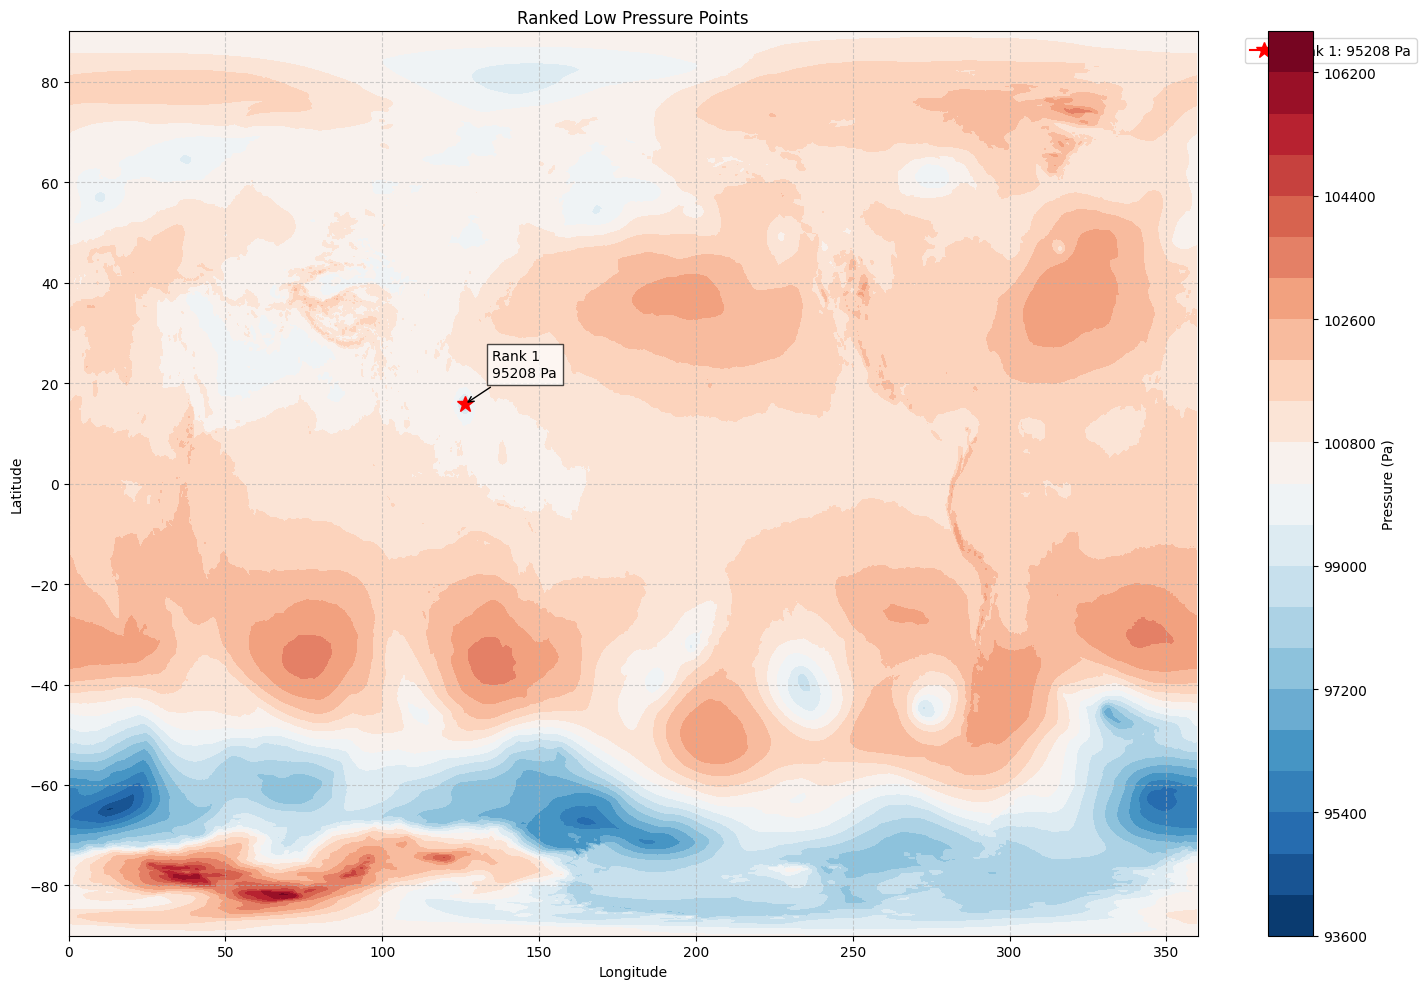

In [149]:
plt.figure(figsize=(15, 10))

# 전체 기압 분포도 표시
plt.contourf(lons, lats, pressure_data, levels=20, cmap='RdBu_r')
plt.colorbar(label='Pressure (Pa)')

# 선택된 지점들 표시 (순위와 함께)
colors = ['red', 'orange', 'yellow', 'green', 'blue']
markers = ['*', 'o', 's', '^', 'D']

for i, (point, color, marker) in enumerate(zip(significant_points, colors, markers)):
    plt.plot(point['lon'], point['lat'], marker=marker, color=color, 
            markersize=12, label=f"Rank {i+1}: {point['pressure']:.0f} Pa")
    
    # 주석 위치 조정 (겹치지 않게)
    plt.annotate(f"Rank {i+1}\n{point['pressure']:.0f} Pa",
                (point['lon'], point['lat']),
                xytext=(20, 20),  # 모든 주석의 기본 위치
                textcoords='offset points',
                bbox=dict(facecolor='white', alpha=0.7),
                arrowprops=dict(arrowstyle='->'))

plt.title('Ranked Low Pressure Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True, linestyle='--', alpha=0.6)

# 전체 맵 표시를 위한 축 범위 설정
plt.xlim(0, 360)
plt.ylim(-90, 90)

plt.tight_layout()
plt.show()


## 태풍 경계 판별
- 주변 지역과의 기압 차이를 계산 
- 급격한 기압 경도는 강한 바람과 순환을 나타냄

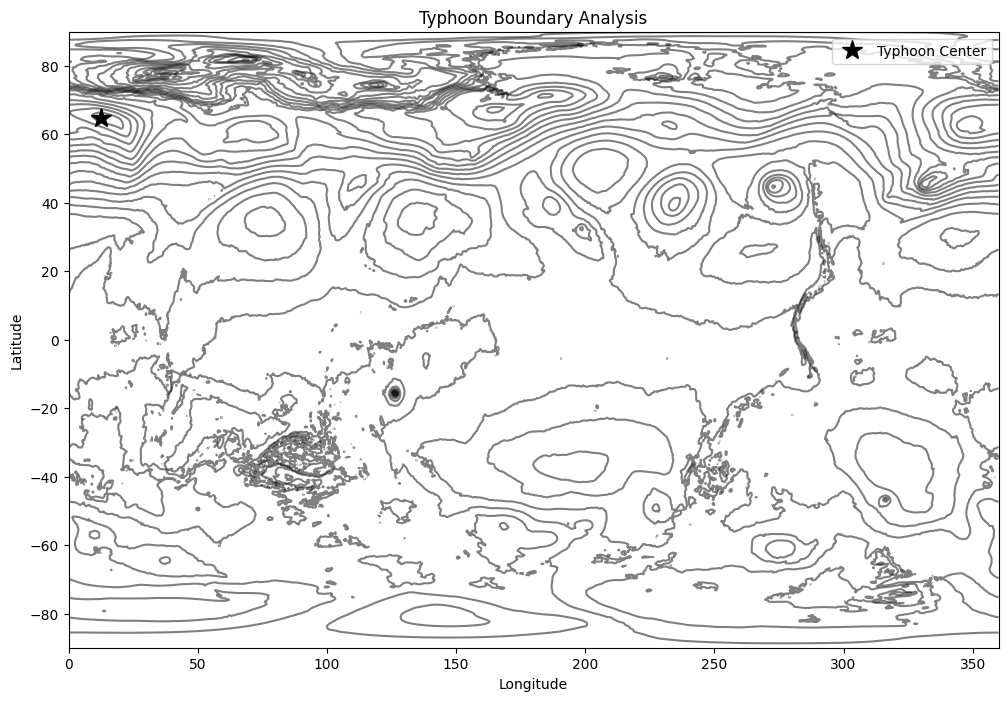

In [114]:
# 태풍 경계 임계값 설정 (예시값, 실제 데이터에 따라 조정 필요)
vorticity_threshold = np.std(vorticity) * 2
owz_threshold = np.std(owz) * 2

# 태풍 영역 마스크 생성
typhoon_mask = (np.abs(vorticity) > vorticity_threshold) & (owz > owz_threshold)

# 태풍 경계 시각화
plt.figure(figsize=(12, 8))
plt.contourf(lons, lats, typhoon_mask, levels=2, colors=['white', 'red'], alpha=0.3)
plt.contour(lons, lats, pressure_data, levels=20, colors='black', alpha=0.5)
plt.title('Typhoon Boundary Analysis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot(center_lon, center_lat, 'k*', markersize=15, label='Typhoon Center')
plt.legend()
plt.show()
